In [30]:
import os
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import class_weight
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model

In [20]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("GPU memory growth enabled")
    except RuntimeError as e:
        print(e)

Num GPUs Available:  2
GPU memory growth enabled


In [2]:
image_folder = '/home/uday.g/Projects/Cell_type_classification/dataset2-master/dataset2-master/images/'

In [3]:
cell_types = ['EOSINOPHIL', 'LYMPHOCYTE', 'MONOCYTE', 'NEUTROPHIL']

In [4]:
train_image_files = {}
test_image_files = {}
y_train_cat = []
y_test_cat = []

In [5]:
for i in cell_types:
    train_image_files[i] = os.listdir(f'{image_folder}TRAIN/{i}/')
    y_train_cat.append(i)
    
for i in cell_types:
    test_image_files[i] = os.listdir(f'{image_folder}TEST/{i}/')
    y_test_cat.append(i)

In [6]:
img_x = 224
img_y = 224

x_train = []
y_train = []
x_test_val = []
y_test_val = []


for cell in train_image_files.keys():
    for f in train_image_files[cell]:
        label = cell
        img_path = f'{image_folder}TRAIN/{cell}/{f}'
        if not os.path.exists(img_path):
            continue
        img = cv2.imread(img_path)
        if img is None:
            continue
        img = cv2.resize(img, (img_x, img_y))
        img = img / 255
        x_train.append(img)
        y_train.append(cell_types.index(label))
        

for cell in test_image_files.keys():
    for f in test_image_files[cell]:
        label = cell
        img_path = f'{image_folder}TEST/{cell}/{f}'
        if not os.path.exists(img_path):
            continue
        img = cv2.imread(img_path)
        if img is None:
            continue
        img = cv2.resize(img, (img_x, img_y))
        img = img / 255
        x_test_val.append(img)
        y_test_val.append(cell_types.index(label))
        
        
# for _, row in labels_df.iterrows():
#     img_id = row['Image']
#     label = row['Cleaned_Category']
#     img_id = f'{"0"*(3 - len(str(img_id)))}{str(img_id)}'
#     img_path = f'{image_folder}/BloodImage_00{img_id}.jpg'
# #     print(img_path)
#     if not os.path.exists(img_path):
#         continue
#     img = cv2.imread(img_path)
#     if img is None:
#         continue
#     img = cv2.resize(img, (img_x, img_y))
#     img = img / 255
#     x.append(img)
#     y.append(cell_types.index(label))

x_train = np.array(x_train)
y_train = np.array(y_train)
x_test_val = np.array(x_test_val)
y_test_val = np.array(y_test_val)

In [7]:
y_train.shape, x_train.shape, y_test_val.shape, x_test_val.shape

((9957,), (9957, 224, 224, 3), (2487,), (2487, 224, 224, 3))

In [8]:
y_train_cat = to_categorical(y_train, num_classes=len(cell_types))
y_test_val_cat = to_categorical(y_test_val, num_classes=len(cell_types))

In [9]:
y_test_val_cat

array([[1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       ...,
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.]], shape=(2487, 4))

In [10]:
x_test, x_val, y_test, y_val = train_test_split(
    x_test_val, y_test_val_cat, test_size=0.30, stratify=np.argmax(y_test_val_cat, axis=1)
)

In [11]:
x_test.shape, y_test.shape, x_val.shape, y_val.shape

((1740, 224, 224, 3), (1740, 4), (747, 224, 224, 3), (747, 4))

In [12]:
y_train = y_train_cat
y_train

array([[1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       ...,
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.]], shape=(9957, 4))

In [13]:
indices = np.arange(x_train.shape[0])   # create an array of indexes
np.random.shuffle(indices)              # shuffle indexes

# apply shuffled indexes to X and y
x_train = x_train[indices]
y_train = y_train[indices]

In [14]:
indices = np.arange(x_test.shape[0])   # create an array of indexes
np.random.shuffle(indices)              # shuffle indexes

# apply shuffled indexes to X and y
x_test = x_test[indices]
y_test = y_test[indices]

In [15]:
indices = np.arange(x_val.shape[0])   # create an array of indexes
np.random.shuffle(indices)              # shuffle indexes

# apply shuffled indexes to X and y
x_val = x_val[indices]
y_val = y_val[indices]

In [ ]:
# aug = ImageDataGenerator(
#     rotation_range=20,
#     width_shift_range=0.1,
#     height_shift_range=0.1,
#     zoom_range=0.1,
#     horizontal_flip=True
# )

# # Threshold for minority classes
# minority_classes = ['BASOPHIL', 'MONOCYTE', 'LYMPHOCYTE']

# x_aug = []
# y_aug = []

# for cls in minority_classes:
#     cls_index = cell_types.index(cls)
#     cls_samples = x_train[np.argmax(y_train, axis=1) == cls_index]
#     cls_labels = y_train[np.argmax(y_train, axis=1) == cls_index]
    
#     # Augment each image multiple times
#     for i in range(len(cls_samples)):
#         img = np.expand_dims(cls_samples[i], 0)
#         label = cls_labels[i]
#         # Generate 5 augmented images per original
#         for batch in aug.flow(img, batch_size=1):
#             x_aug.append(batch[0])
#             y_aug.append(label)
#             if len(X_aug) >= 5 * len(cls_samples):  # 5x augmentation
#                 break

# # Convert lists to arrays
# x_aug = np.array(X_aug)
# y_aug = np.array(y_aug)

# # Combine with original training set
# x_train_balanced = np.concatenate([x_train, x_aug], axis=0)
# y_train_balanced = np.concatenate([y_train, y_aug], axis=0)

# print("Original train size:", x_train.shape[0])
# print("Augmented train size:", X_train_balanced.shape[0])

In [ ]:
# print("Original train size:", y_train.shape[0])
# print("Augmented train size:", y_train_balanced.shape[0])

In [16]:
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    vertical_flip=True
)

In [17]:
datagen.fit(x_train)

In [21]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(img_x, img_y, 3)),
    MaxPooling2D(2, 2),
    
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(len(cell_types), activation='softmax')
])

/home/uday.g/.conda/envs/usago_env/lib/python3.13/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1759866097.568795  348163 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9528 MB memory:  -> device: 0, name: Quadro RTX 5000, pci bus id: 0000:af:00.0, compute capability: 7.5
I0000 00:00:1759866097.569517  348163 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 14826 MB memory:  -> device: 1, name: Quadro RTX 5000, pci bus id: 0000:d8:00.0, compute capability: 7.5


In [70]:
# y_integers = np.argmax(y_train, axis=1)
# weights = class_weight.compute_class_weight(
#     class_weight='balanced',
#     classes=np.unique(y_integers),
#     y=y_integers
# )

# class_weights = {i: w for i, w in enumerate(weights)}
# print("Class weights:", class_weights)

Class weights: {0: np.float64(0.9968962755306368), 1: np.float64(1.002517116391462), 2: np.float64(1.0045399515738498), 3: np.float64(0.9960984393757503)}


In [22]:
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

model.compile(optimizer=Adam(1e-4), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

history = model.fit(datagen.flow(x_train, y_train, batch_size=32),
                   validation_data=(x_val, y_val),
                   epochs=30,
                   callbacks=[early_stop]
        )

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    11,075,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,169,476 (42.61 MB)

 Trainable params: 11,169,476 (42.61 MB)

 Non-trainable params: 0 (0.00 B)

/home/uday.g/.conda/envs/usago_env/lib/python3.13/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30


2025-10-08 01:12:08.942569: I external/local_xla/xla/service/service.cc:163] XLA service 0x7f61c00054a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-10-08 01:12:08.942630: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): Quadro RTX 5000, Compute Capability 7.5
2025-10-08 01:12:08.942644: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (1): Quadro RTX 5000, Compute Capability 7.5
2025-10-08 01:12:09.049445: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-10-08 01:12:09.526861: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 90501
2025-10-08 01:12:10.990421: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:546] Omitted potentially buggy algorithm eng14{k25=0} for conv (f32[32,32,222,222]{3,2,1,0}, u8[0]{0}) custom-ca

  1/312 ━━━━━━━━━━━━━━━━━━━━ 41:36 8s/step - accuracy: 0.4062 - loss: 1.3660

I0000 00:00:1759866134.723369  348477 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


284/312 ━━━━━━━━━━━━━━━━━━━━ 8s 295ms/step - accuracy: 0.2767 - loss: 1.3924

2025-10-08 01:13:38.898396: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:546] Omitted potentially buggy algorithm eng14{k25=0} for conv (f32[5,32,222,222]{3,2,1,0}, u8[0]{0}) custom-call(f32[5,3,224,224]{3,2,1,0}, f32[32,3,3,3]{3,2,1,0}, f32[32]{0}), window={size=3x3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false,"reification_cost":[]}
2025-10-08 01:13:39.011072: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:546] Omitted potentially buggy algorithm eng14{k25=0} for conv (f32[5,64,109,109]{3,2,1,0}, u8[0]{0}) custom-call(f32[5,32,111,111]{3,2,1,0}, f32[64,32,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivatio

312/312 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step - accuracy: 0.2797 - loss: 1.3899

2025-10-08 01:13:50.589679: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:546] Omitted potentially buggy algorithm eng14{k25=0} for conv (f32[32,32,222,222]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,3,224,224]{3,2,1,0}, f32[32,3,3,3]{3,2,1,0}, f32[32]{0}), window={size=3x3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"activation_mode":"kRelu","conv_result_scale":1,"side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false,"reification_cost":[]}
2025-10-08 01:13:50.634390: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:546] Omitted potentially buggy algorithm eng14{k25=0} for conv (f32[32,64,109,109]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,32,111,111]{3,2,1,0}, f32[64,32,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActiv

312/312 ━━━━━━━━━━━━━━━━━━━━ 106s 314ms/step - accuracy: 0.3130 - loss: 1.3614 - val_accuracy: 0.4444 - val_loss: 1.2269
Epoch 2/30
312/312 ━━━━━━━━━━━━━━━━━━━━ 94s 299ms/step - accuracy: 0.4597 - loss: 1.1877 - val_accuracy: 0.5730 - val_loss: 0.9782
Epoch 3/30
312/312 ━━━━━━━━━━━━━━━━━━━━ 93s 299ms/step - accuracy: 0.5895 - loss: 0.9675 - val_accuracy: 0.6493 - val_loss: 0.8405
Epoch 4/30
312/312 ━━━━━━━━━━━━━━━━━━━━ 93s 298ms/step - accuracy: 0.6362 - loss: 0.8486 - val_accuracy: 0.6720 - val_loss: 0.7983
Epoch 5/30
312/312 ━━━━━━━━━━━━━━━━━━━━ 93s 298ms/step - accuracy: 0.6825 - loss: 0.7508 - val_accuracy: 0.6854 - val_loss: 0.7463
Epoch 6/30
312/312 ━━━━━━━━━━━━━━━━━━━━ 93s 298ms/step - accuracy: 0.7151 - loss: 0.6754 - val_accuracy: 0.7229 - val_loss: 0.7125
Epoch 7/30
312/312 ━━━━━━━━━━━━━━━━━━━━ 96s 306ms/step - accuracy: 0.7324 - loss: 0.6200 - val_accuracy: 0.6854 - val_loss: 0.7252
Epoch 8/30
312/312 ━━━━━━━━━━━━━━━━━━━━ 93s 297ms/step - accuracy: 0.7584 - loss: 0.5610 - va

In [23]:
loss, acc = model.evaluate(x_test, y_test)
print(f'loss: {loss} and accuracy: {acc}')

53/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8234 - loss: 0.3768

2025-10-08 01:59:28.260042: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:546] Omitted potentially buggy algorithm eng14{k25=0} for conv (f32[12,32,222,222]{3,2,1,0}, u8[0]{0}) custom-call(f32[12,3,224,224]{3,2,1,0}, f32[32,3,3,3]{3,2,1,0}, f32[32]{0}), window={size=3x3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"activation_mode":"kRelu","conv_result_scale":1,"side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false,"reification_cost":[]}
2025-10-08 01:59:28.330627: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:546] Omitted potentially buggy algorithm eng14{k25=0} for conv (f32[12,64,109,109]{3,2,1,0}, u8[0]{0}) custom-call(f32[12,32,111,111]{3,2,1,0}, f32[64,32,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActiv

55/55 ━━━━━━━━━━━━━━━━━━━━ 4s 73ms/step - accuracy: 0.8322 - loss: 0.3583
loss: 0.3583270311355591 and accuracy: 0.8321838974952698


In [24]:
model.save("cell_classification_cnn.h5")
print("model saved as cell_classificaiton_cnn.h5 file")

model saved as cell_classificaiton_cnn.h5 file


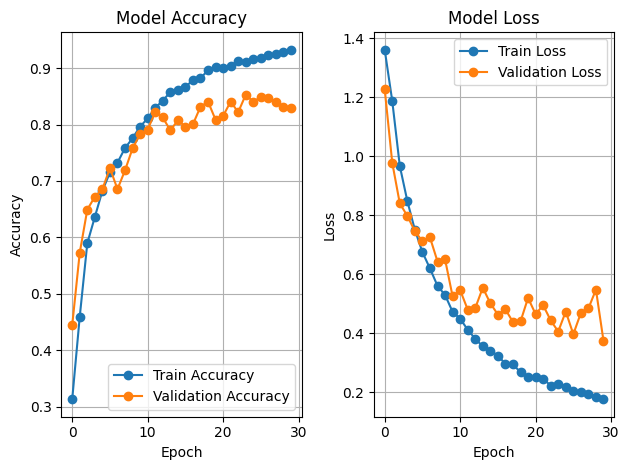

In [25]:
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='o')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Plot training & validation loss
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', marker='o')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [26]:
y_pred_probs = model.predict(x_test)

# Convert probabilities to class labels
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step


In [27]:
cm = confusion_matrix(y_true, y_pred)

<Figure size 800x600 with 0 Axes>

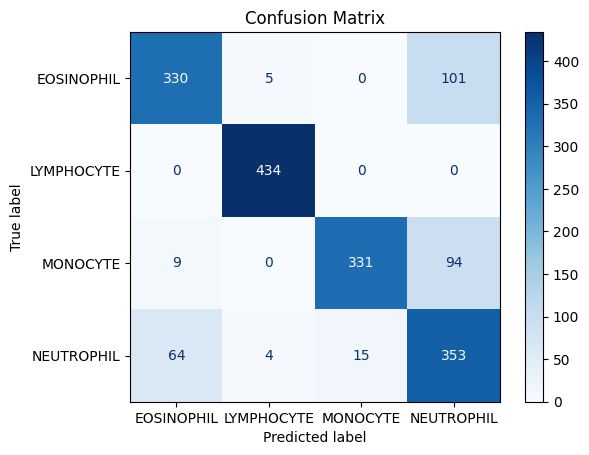

In [28]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=cell_types)
plt.figure(figsize=(8,6))
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title("Confusion Matrix")
plt.show()